# **Method 1: Thresholding**

Saving Leaves.PNG to Leaves.PNG


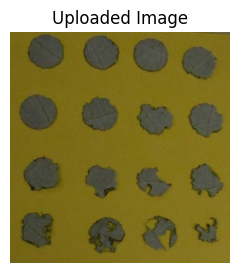

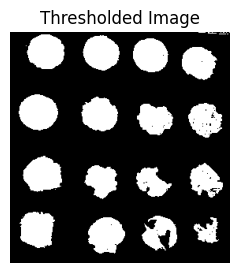

Area Matrix (in pixels):
[[1644 1567 1525 1411]
 [1743 1520 1296 1316]
 [1669 1201 1007 1137]
 [1603 1457 1187  657]]

Percentage Matrix (in %):
[[ 94.32013769  89.90246701  87.49282846  80.95238095]
 [100.          87.20596672  74.3545611   75.50200803]
 [ 95.75444636  68.90418818  57.77395295  65.232358  ]
 [ 91.96787149  83.59150889  68.10097533  37.69363167]]


In [1]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Upload the image of leaves damaged in 4 weeks
uploaded = files.upload()
image_filename = next(iter(uploaded))

# Read the uploaded image in color
uploaded_image = cv2.imread(image_filename)

# Ensure the image was loaded
if uploaded_image is None:
    raise ValueError("Image not found. Please check the path and ensure it is correct.")

# Convert to grayscale for thresholding
image_gray = cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding to segment the leaves
retval, thresholded_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Initialize a list to store the area of each leaf
leaf_areas = []

# Loop through each leaf section and calculate the area
for i in range(4):
    for j in range(4):
        # Define the coordinates for each leaf section
        x_start = j * int(image_gray.shape[1] / 4)
        x_end = (j + 1) * int(image_gray.shape[1] / 4)
        y_start = i * int(image_gray.shape[0] / 4)
        y_end = (i + 1) * int(image_gray.shape[0] / 4)

        # Crop the image to the current leaf section
        leaf_section = thresholded_image[y_start:y_end, x_start:x_end]

        # Calculate the area of the leaf (count of white pixels)
        leaf_area = np.sum(leaf_section == 255)
        leaf_areas.append(leaf_area)

# Check if we have 16 leaf areas before reshaping
if len(leaf_areas) == 16:
    # Use the max area (the least damaged leaf area) as the reference to calculate percentage
    reference_leaf_area = max(leaf_areas)

    # Initialize matrices to store the area and percentage values
    area_matrix = np.array(leaf_areas).reshape(4, 4)
    percentage_matrix = (area_matrix / reference_leaf_area) * 100
else:
    raise ValueError("Incorrect number of leaf areas calculated. Expected 16, got {}".format(len(leaf_areas)))

# Show the original color image with a title using matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2RGB))
plt.title('Uploaded Image')
plt.axis('off')
plt.show()

# Visualize the thresholded image using matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()

# Print out the matrices
print("Area Matrix (in pixels):")
print(area_matrix)
print("\nPercentage Matrix (in %):")
print(percentage_matrix)


# **Method 2: Edge Detection**

Saving Leaves.PNG to Leaves (3).PNG


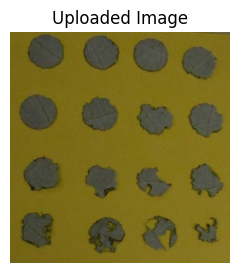

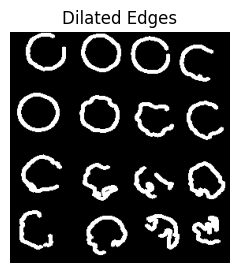

Area Matrix (in pixels):
[[ 543.   628.5  692.5  458.5]
 [ 148.5  362.5  590.  1552.5]
 [ 566.5  517.   482.  1833.5]
 [2046.   442.5  579.  1883. ]]

Percentage Matrix (in %):
[[ 26.53958944  30.71847507  33.84652981  22.40957967]
 [  7.25806452  17.71749756  28.83675464  75.8797654 ]
 [ 27.68817204  25.2688172   23.55816227  89.61388074]
 [100.          21.62756598  28.29912023  92.03323558]]


In [4]:
from google.colab import files
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Upload the image of leaves damaged in 4 weeks
uploaded = files.upload()
image_filename = next(iter(uploaded))

# Read the uploaded image in color
image_color = cv2.imread(image_filename)

# Ensure the image was loaded
if image_color is None:
    raise ValueError("Image not found. Please check the path and ensure it is correct.")

# Convert to grayscale for edge detection
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise and improve edge detection
blurred_image = cv2.GaussianBlur(image_gray, (5, 5), 0)

# Use the median of the grayscale image to auto-calculate the thresholds
sigma = 0.33
v = np.median(blurred_image)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))

# Apply Canny edge detection to find the edges of the leaves
edges = cv2.Canny(blurred_image, lower, upper)

# Creating a 5x5 elliptical structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Applying dilation with the custom kernel
dilated_edges = cv2.dilate(edges, kernel)

# Find contours from the dilated edges, assuming that the external contours are the leaf edges
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Use the largest contour (the least damaged leaf) as the reference to calculate percentage
reference_leaf_area = max(cv2.contourArea(contour) for contour in contours)

# Initialize matrices to store the area and percentage values
area_matrix = np.zeros((4, 4))
percentage_matrix = np.zeros((4, 4))

# Process only the first 16 contours, which should correspond to the leaves
for i in range(min(16, len(contours))):
    # Calculate the area of the current leaf
    leaf_area = cv2.contourArea(contours[i])

    # Calculate the row and column index for the leaf
    row, col = divmod(i, 4)
    if row < 4 and col < 4:  # Ensure indices are within bounds
        area_matrix[row, col] = leaf_area
        percentage_matrix[row, col] = (leaf_area / reference_leaf_area) * 100

# Show the original color image with a title using matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title('Uploaded Image')
plt.axis('off')
plt.show()

# Show the processed image with the dilated edges using matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(dilated_edges, cmap='gray')
plt.title('Dilated Edges')
plt.axis('off')
plt.show()

# Print out the matrices
print("Area Matrix (in pixels):")
print(area_matrix)
print("\nPercentage Matrix (in %):")
print(percentage_matrix)


# **Method 3: Color Segmentation**

Saving Leaves.PNG to Leaves (4).PNG


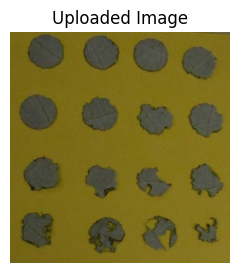

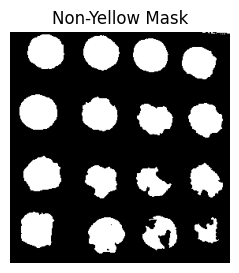

Area Matrix (in pixels):
[[1618 1539 1509 1394]
 [1712 1495 1289 1368]
 [1605 1184  989 1162]
 [1542 1425 1154  639]]

Percentage Matrix (in %):
[[ 94.50934579  89.89485981  88.14252336  81.42523364]
 [100.          87.32476636  75.29205607  79.90654206]
 [ 93.75        69.1588785   57.76869159  67.87383178]
 [ 90.07009346  83.23598131  67.40654206  37.32476636]]


In [5]:
# Method 3. Color Segmentation

import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Upload the image of leaves damaged in 4 weeks
uploaded = files.upload()
image_filename = next(iter(uploaded))

# Read the uploaded image in color
uploaded_image = cv2.imread(image_filename)

# Ensure the image was loaded
if uploaded_image is None:
    raise ValueError("Image not found. Please check the path and ensure it is correct.")

# Convert the image from BGR to HSV color space
image_hsv = cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2HSV)

# Define the yellow color range in HSV
lower_yellow = np.array([20, 100, 100])  # Lower bound of yellow color
upper_yellow = np.array([30, 255, 255])  # Upper bound of yellow color

# Create a mask for yellow color
yellow_mask = cv2.inRange(image_hsv, lower_yellow, upper_yellow)

# Invert the mask to get non-yellow parts of the image
non_yellow_mask = cv2.bitwise_not(yellow_mask)

# Initialize a list to store the area of each leaf
leaf_areas = []

# Loop through each leaf section and calculate the area
for i in range(4):
    for j in range(4):
        # Define the coordinates for each leaf section
        x_start = j * int(uploaded_image.shape[1] / 4)
        x_end = (j + 1) * int(uploaded_image.shape[1] / 4)
        y_start = i * int(uploaded_image.shape[0] / 4)
        y_end = (i + 1) * int(uploaded_image.shape[0] / 4)

        # Crop the mask to the current leaf section
        leaf_section_mask = non_yellow_mask[y_start:y_end, x_start:x_end]

        # Calculate the area of the leaf (count of non-yellow pixels)
        leaf_area = np.sum(leaf_section_mask == 255)
        leaf_areas.append(leaf_area)

# Use the largest area (the least damaged leaf) as the reference to calculate percentage
reference_leaf_area = max(leaf_areas)

# Initialize matrices to store the area and percentage values
area_matrix = np.array(leaf_areas).reshape(4, 4)
percentage_matrix = (area_matrix / reference_leaf_area) * 100


# Show the original color image with a title using matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2RGB))
plt.title('Uploaded Image')
plt.axis('off')
plt.show()

# Visualize the non-yellow mask using matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(non_yellow_mask, cmap='gray')
plt.title('Non-Yellow Mask')
plt.axis('off')
plt.show()

# Print out the matrices
print("Area Matrix (in pixels):")
print(area_matrix)
print("\nPercentage Matrix (in %):")
print(percentage_matrix)
